<a href="https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/LibraryNet/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST

Author: Maxim Ziatdinov

Contact e-mail: ziatdinovmax@gmail.com

Here we are going to use a deep neural network and simple analysis of lattice graph structures to create a library of Si pont defects in graphene. The defects are categorized based on the number of atoms in the first coordination sphere of each detected dopant. This analysis should also work for other systems (but will require a different training set for a neural network) where there is a known impurity in a host lattice, which can have different configurations (e.g. dimer, trimer, different number of bonds to the nearby host lattice atoms, etc.).

To run it in Colab, first execute the cell below:

(alternatively, you can run it with a Jupyter Lab/Notebook on your local machine)

In [ ]:
%%shell
git clone https://github.com/pycroscopy/AICrystallographer.git
cp -r AICrystallographer/LibraryNet/* .

Import modules:

In [2]:
import glob
import numpy as np
import dcnn
from atomfind import *
import graphs
from utils import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", module="networkx")

We first get a list of filepaths for the test data. Here we store our data in the hdf5 file format with a very simple structure. Specifically, it containce only two datasets: a single experimental image in the form of 2d numpy array and metadata in the json format.

In [3]:
filelist = glob.glob('test_data/*.hdf5')
filelist

['test_data/test-1.hdf5', 'test_data/test-2.hdf5']

We need to specify the host lattice atoms (here, it is graphene, hence 'C') and the dopant atoms (here it is 'Si'). We also need to specify maximum possible bond lengths between these atomic species (if we don't do it here, we will be promted to enter those values when running the analysis).

In [4]:
atoms = OrderedDict()
atoms['lattice_atom'] = 'C'
atoms['dopant'] = 'Si'
approx_max_bonds = {('Si', 'Si'): 250, ('C', 'C'): 175, ('Si', 'C'): 210}

Finally we can run the analysis and obtain information on the type of atomic defects in our system within just several seconds. Each analyzed defect is stored in the folder whose name correspond to a defect class. The files are saved in the hdf5 file format and contain a dataset corresponding to the image and a dataset corresponding to the defect(s) coordinates. Noice that here we will be asked to choose whether to save file or not (although this option can be disabled), which allows for a domain expert to double check the output. That said, for the very large amounts of data, such manual confirmation may not be feasible. In that case, set *save_all=True* in the *graphs.construct_graphs* function.

Loaded 1 image of the size 256 by 256
Sample name: Graphene monolayer
Type of experiment: HAADF
1 image was decoded in approximately 0.71 seconds
Atomic/defect coordinates extracted


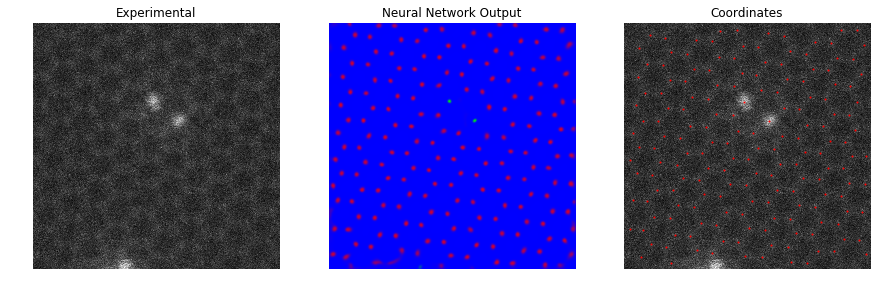

Found the following atomic species: C, Si
Created 170 graph nodes corresponding to atomic species
All lattice atoms not directly connected to a dopant have been removed
Refinement procedure based on the maximum coordination number has been completed


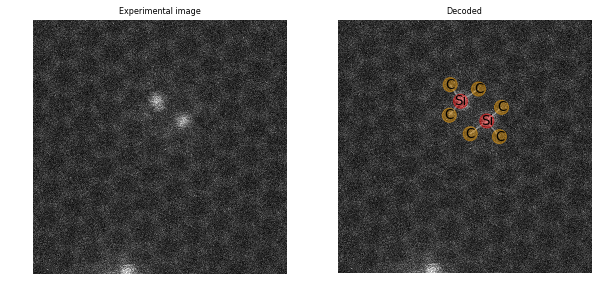


Identified 2 defect structures
Defect 1:
 Defect formula: Si1C3 Defect position: [123.19, 78.12]


Save data: [Y]es or [N]o
 N


Defect 2:
 Defect formula: Si1C3 Defect position: [153.34, 105.49]


Save data: [Y]es or [N]o
 N


Loaded 1 image of the size 256 by 256
Sample name: Graphene monolayer
Type of experiment: HAADF
1 image was decoded in approximately 0.45 seconds
Atomic/defect coordinates extracted


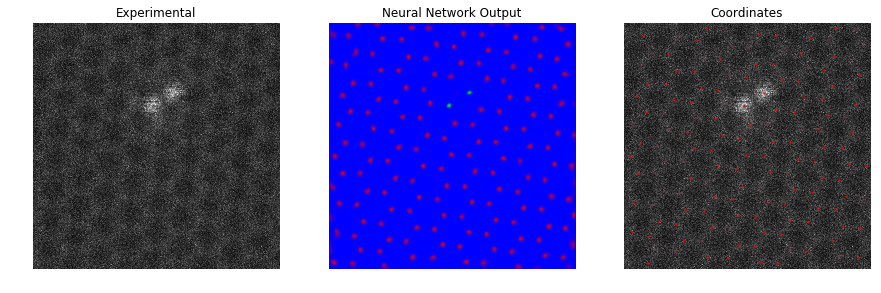

Found the following atomic species: C, Si
Created 143 graph nodes corresponding to atomic species
All lattice atoms not directly connected to a dopant have been removed
Refinement procedure based on the maximum coordination number has been completed


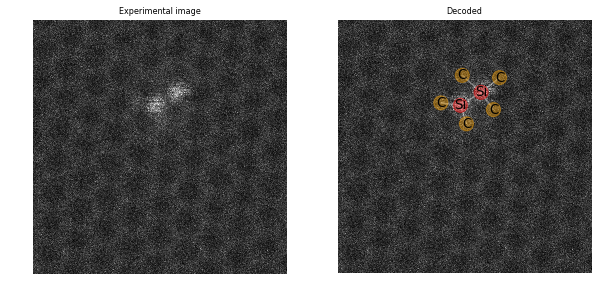


Identified 1 defect structures
Defect 1:
 Defect formula: Si2C5 Defect position: [135.69, 78.72]


Save data: [Y]es or [N]o
 N


In [19]:
# Folder and filename for the saved weights
weights_folder = './saved_models/'
weights_file = 'G-Si-m-2-3-best_weights.pt'
# Load model skeleton
model = dcnn.atomsegnet(nb_classes=3)
# Load trained weights
model = dcnn.load_torchmodel(weights_folder+weights_file, model)
# iterate over files with image data
for filename in filelist:
    imgdata, metadata = open_hdf(filename)
    img_size = metadata['scan size']
    # Apply a trained model to the loaded data
    img, dec = dl_image(imgdata, model, nb_classes=3).decode()
    # Get atomic coordinates
    coord = find_atoms(dec).get_all_coordinates()
    # plot results of dcnn based decoding
    y, x,_ = coord[0].T
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img[0, :, :, 0], cmap='gray')
    ax[0].set_title('Experimental')
    ax[1].imshow(dec[0, :, :, :], cmap='jet', Interpolation='Gaussian')
    ax[1].set_title('Neural Network Output')
    ax[2].imshow(img[0, :, :, 0], cmap='gray')
    ax[2].scatter(x, y, s=1, c='red')
    ax[2].set_title('Coordinates')
    for _ax in fig.axes:
        _ax.axis('off')
    plt.show()
    # construct and plot graph
    if len(coord[0]) > 0:
        graphs.construct_graphs(img, img_size, coord[0], atoms,
                         approx_max_bonds, filename)

We can then also read the saved files and display both the images and coordinates: 

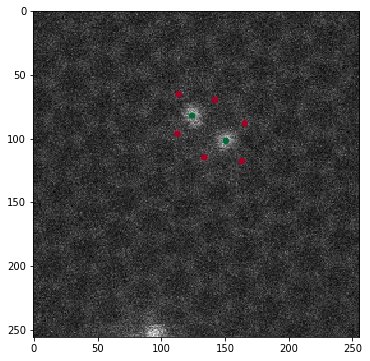

In [41]:
# Specify filepath
path = 'library_test/Si1C3/'
library_file = 'test-1.hdf5'
# read data (image+defect coordinates)
img, img_size, coord = open_library_hdf(path+library_file, atoms)
# plot image and defect cordinates
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img[0, :, :, 0], cmap = 'gray')
ax.scatter(coord[:, 1], coord[:, 0], c = coord[:, 2]+1, s=30, cmap='RdYlGn')

We can also easily reconstruct subgraphs associated with defects. We just need to specify raw_data=False, which indicates that we are viewing a library data and not a new raw input.

Found the following atomic species: C, Si
Created 8 graph nodes corresponding to atomic species
All lattice atoms not directly connected to a dopant have been removed
Refinement procedure based on the maximum coordination number has been completed


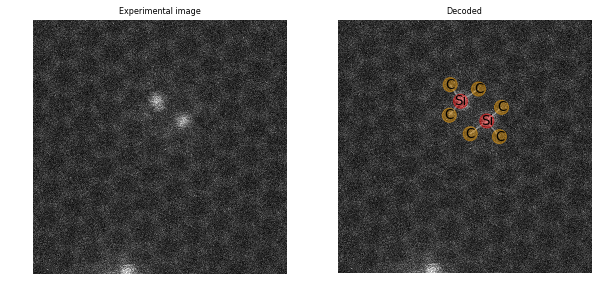


Identified 2 defect structures
Defect 1:
 Defect formula: Si1C3 Defect position: [123.19, 78.12]
Defect 2:
 Defect formula: Si1C3 Defect position: [153.34, 105.49]


In [42]:
defects = graphs.construct_graphs(img, img_size, coord, atoms,
                         approx_max_bonds, raw_data=False)

We can also introduce subcategories to distringuish defects that have the same formula but different degree of distortion. Let's get information on the bond angles and bond lengths for defects that we just loaded:

In [43]:
for i, sg in enumerate(defects):
    print('Defect {} Si-C angles:'.format(i+1), 
          graphs.get_angles(sg, atoms['dopant']))
    print('Defect {} Si-C bonds (pm):'.format(i+1),
          graphs.get_bond_lengths(sg, atoms['dopant'], img_size, img))      

Defect 1 Si-C angles: [163.11897621 109.27651453  87.60450926]
Defect 1 Si-C bonds (pm): [154.62380325 171.13588415 141.44104587]
Defect 2 Si-C angles: [174.91103462  93.94860964  91.14035574]
Defect 2 Si-C bonds (pm): [158.2543561  165.16328866 158.44499692]


One can see that there is a large variation in the bond angles. Let's identify a threshold above which a defect is categorized as 'distorted' and run a binary classification for each defect ('distorted' vs. 'undistorted')

In [49]:
import os
from collections import Counter
# Define a criterion to separate distorted defects.
def criterion():
    return np.std(graphs.get_angles(sg, atoms['dopant'])) > 15
# Iterate over defects in the image
for i, sg in enumerate(defects):
    atom_list = []
    for n in sg.nodes():
        atom_list.append(n.split(' ')[0])
    n_imp = Counter(atom_list)[atoms['dopant']]
    n_host = Counter(atom_list)[atoms['lattice_atom']]
    defect_formula = atoms['dopant'] + str(n_imp) + atoms['lattice_atom'] + str(n_host)
    defect_position, defect_coord = graphs.get_defect_coord(sg)
    # Binary classification based on a defined criterion
    if criterion():
        filepath = 'library_test/' + defect_formula + '_distorted'
    else:
        filepath = 'library_test/' + defect_formula + '_undistorted'
        # Create a directory for each defect formula
    if not os.path.exists(filepath):
            os.makedirs(filepath)
    # save hdf5 file with original and decoded data
    with h5py.File(os.path.join(filepath, library_file), 'a') as f:
        if 'nn_input' not in f.keys():
            nn_input = f.create_dataset('nn_input', data=img)
            nn_input.attrs['scan size'] = img_size
        if 'defect_coord_{}'.format(i) not in f.keys():
            f.create_dataset('defect_coord_{}'.format(i),
                             data=np.string_(defect_coord, encoding="utf-8"))